In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import scatter_matrix
import sys
sys.path.append('..') #get root directory

Let's load our data and look at some of the data we have

In [2]:
housing_data = pd.read_csv("../data/external/housing.csv")
housing_data.head()


,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country
0,2014-05-02 00:00:00,313000.0,3.0,1.50,1340,7912,1.5,0,0,3,1340,0,1955,2005,18810 Densmore Ave N,Shoreline,WA 98133,USA
1,2014-05-02 00:00:00,2384000.0,5.0,2.50,3650,9050,2.0,0,4,5,3370,280,1921,0,709 W Blaine St,Seattle,WA 98119,USA
2,2014-05-02 00:00:00,342000.0,3.0,2.00,1930,11947,1.0,0,0,4,1930,0,1966,0,26206-26214 143rd Ave SE,Kent,WA 98042,USA
3,2014-05-02 00:00:00,420000.0,3.0,2.25,2000,8030,1.0,0,0,4,1000,1000,1963,0,857 170th Pl NE,Bellevue,WA 98008,USA
4,2014-05-02 00:00:00,550000.0,4.0,2.50,1940,10500,1.0,0,0,4,1140,800,1976,1992,9105 170th Ave NE,Redmond,WA 98052,USA


For the housing data, it is all contained within Washington State, USA. So we can ignore the geographic data except for the city columns. There is a finite number of cities in Washington, and which city the house is in provides useful information since some cities are more expensive to live in. We can ignore any houses that are priced at $0. The year in which the house was build and the year in which the house was renovated will be dropped too.

In [3]:
housing_data.drop(['date', 'street', 'statezip', 'country', 'yr_built', 'yr_renovated'], axis = 1, inplace = True)
housing_data = housing_data[housing_data['price'] > 0 ]
housing_data.head()
housing_data.to_csv('../data/interim/housing_data_with_dropped_features.csv') # save the housing data, so we have a dataset that only has the features we want to explore


Before we start to do any data exploration we should split the data into a training set, validation set, and a test set. We will be exploring the data mainly using the training sets and if necessary, the validation sets.

In [ ]:
from sklearn.model_selection import train_test_split
X = housing_data.iloc[:, 1:]# all columns besides the price column
y = housing_data.iloc[:, :1]# only the price column
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size= 0.8, random_state=0)
train_df = pd.concat([X_train, y_train], axis = 1)

In [5]:
X_train.to_csv('../data/interim/X_train.csv')
X_test.to_csv('../data/interim/X_test.csv')
y_train.to_csv('../data/interim/y_train.csv')
y_test.to_csv('../data/interim/y_test.csv')

Our target variable is price, and we want to find out which features have a high correlation with the target variable. We can check for linear correlation between price and the other attributes by using the corr() method.

In [6]:
corr_matrix = train_df.corr(numeric_only = True)
corr_matrix['price'].sort_values(ascending = False)

price            1.000000
sqft_living      0.416307
sqft_above       0.347117
bathrooms        0.328469
view             0.232751
sqft_basement    0.223434
bedrooms         0.200172
waterfront       0.155603
floors           0.127881
sqft_lot         0.044369
condition        0.042264
Name: price, dtype: float64

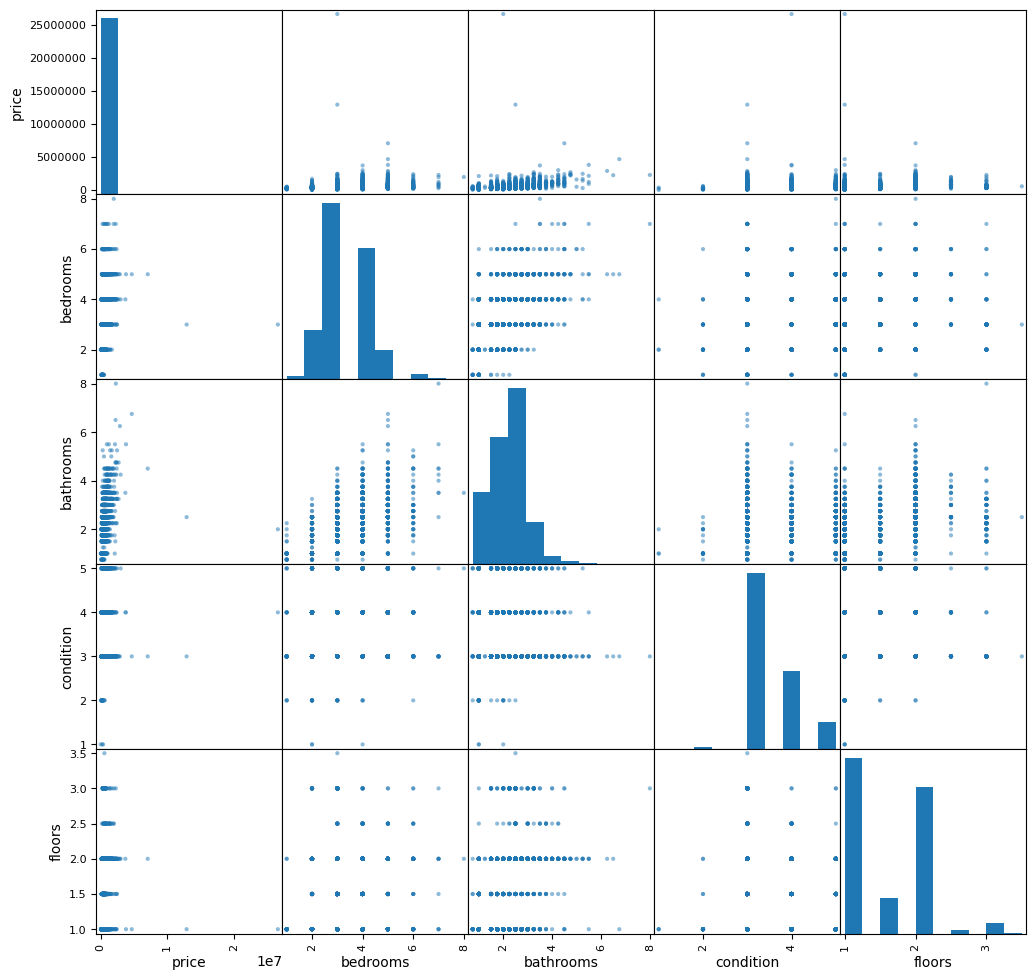

In [7]:
attributes = ["price","bedrooms", "bathrooms", "condition","floors"]
scatter_matrix(train_df[attributes], figsize = (12,12))
plt.show()

The above figures display most of the categorical attributes found in our dataset so it's hard to tell
the correlation between all of them. Now let's plot out more contionus variables and see if we can make some conclusions

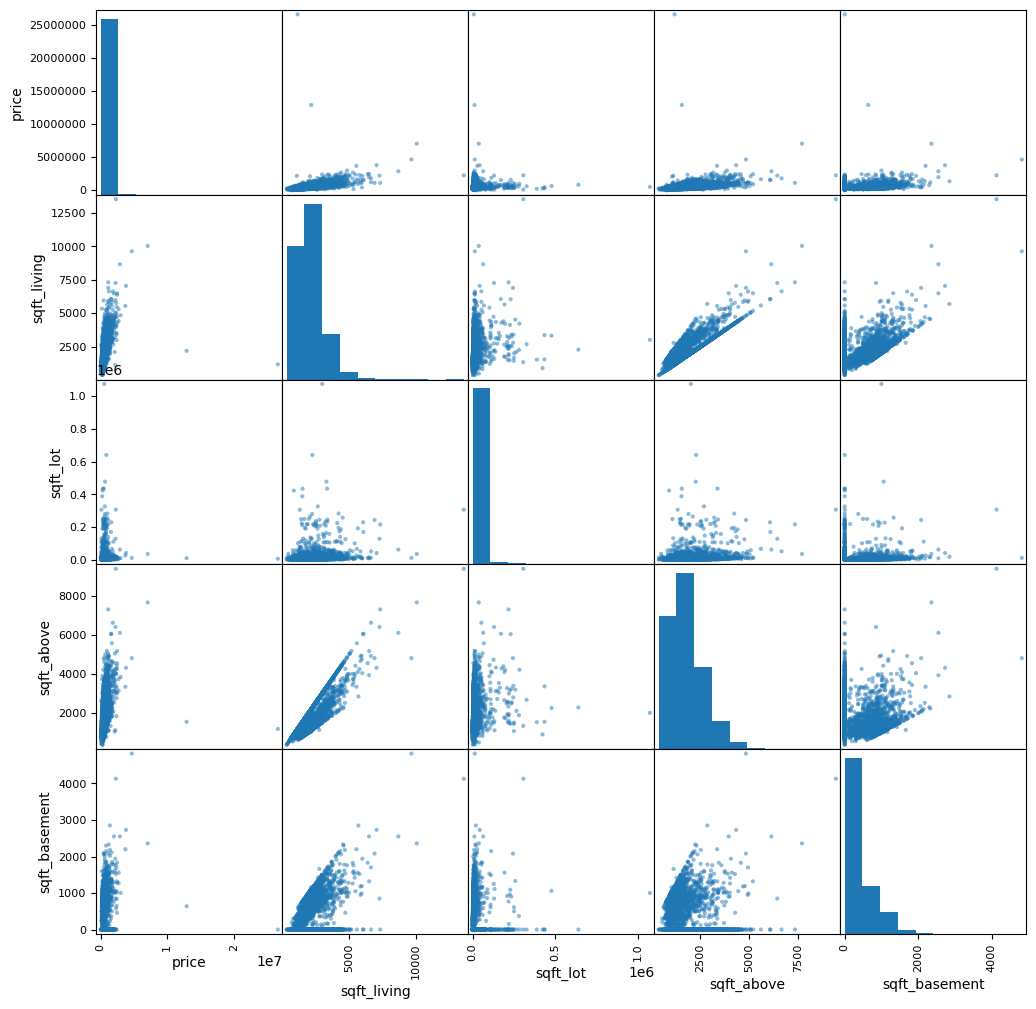

In [8]:
attributes = ["price","sqft_living", "sqft_lot", "sqft_above", 'sqft_basement']
scatter_matrix(train_df[attributes], figsize = (12,12))
plt.show()

There is definitely a lot more visible correlation with the continous attributes which is to be expected. Now I would like to look at plots that look at price vs the other attributes but with price as the y-axis. For the sqft attributes, the histograms are skewed to the right and might be worth eventually transforming by taking the respective logarithms or square roots.

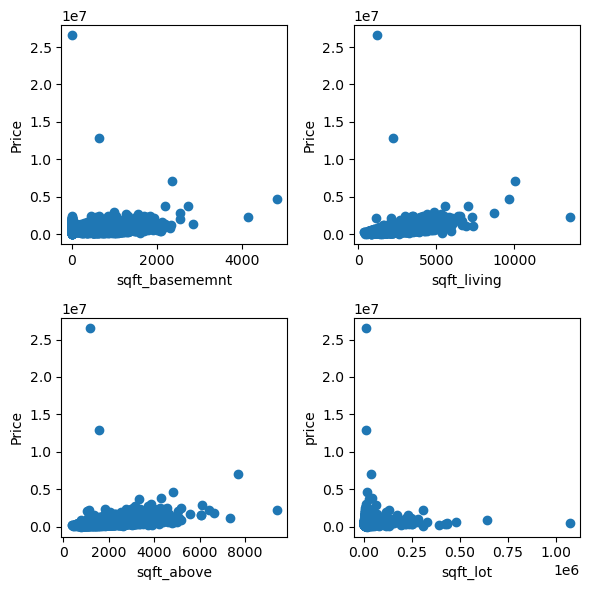

In [9]:
fig, ax = plt.subplots(2,2, figsize = (6,6))

ax[0,0].scatter(train_df['sqft_basement'], train_df['price'])
ax[0,0].set_xlabel('sqft_basememnt')
ax[0,0].set_ylabel('Price')

ax[0,1].scatter(train_df['sqft_living'], train_df['price'])
ax[0,1].set_xlabel('sqft_living')
ax[0,1].set_ylabel('Price')

ax[1,0].scatter(train_df['sqft_above'], train_df['price'])
ax[1,0].set_xlabel('sqft_above')
ax[1,0].set_ylabel('Price')


ax[1,1].scatter(train_df['sqft_lot'], train_df['price'])
ax[1,1].set_xlabel('sqft_lot')
ax[1,1].set_ylabel('price')


plt.tight_layout()
plt.show()

# Handling Categorical Attributes

The only categorical attribute we have is the city column. This is a useful column since cities like Seattle are more expensive to live in as opposed to other cities in Washington. Using a one hot encoder, we are going to transform the column. 



In [10]:
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse_output = False, handle_unknown = 'ignore') # Instead of a SciPy sparse matrix, we get a NumPy array
one_hot_encoded_cities = one_hot_encoder.fit_transform(X_train[['city']])
one_hot_encoded_cities_df = pd.DataFrame(one_hot_encoded_cities, columns = one_hot_encoder.get_feature_names_out(), index = X_train.index)
X_train_encoded = pd.concat([X_train, one_hot_encoded_cities_df], axis = 1) 
X_train_encoded.drop('city', axis = 1, inplace = True) # No need for city column anymore
X_train_encoded.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,...,city_SeaTac,city_Seattle,city_Shoreline,city_Skykomish,city_Snoqualmie,city_Snoqualmie Pass,city_Tukwila,city_Vashon,city_Woodinville,city_Yarrow Point
1992,4.0,1.75,2000,6032,1.0,0,2,3,1300,700,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
871,3.0,2.50,1270,9675,2.0,0,0,3,1270,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
843,3.0,2.50,1480,1663,2.0,0,0,3,1180,300,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2708,4.0,2.75,2630,7505,2.0,0,0,3,2630,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
380,4.0,2.00,1910,6960,1.5,0,0,5,1910,0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
from src.features import encode_cities_val_test_set
X_test_encoded = encode_cities_val_test_set(X_test, one_hot_encoder)

# Feature Scaling & Engineering

From the scatter plots for sqft_basement and sqft_lot it is clear there is a vertical line of data points near or at zero. So it's worth checking how many of the points have values of zero

In [12]:
X_train_encoded[X_train['sqft_lot'] == 0]['sqft_lot'].count()

np.int64(0)

In [13]:
X_train_encoded[X_train['sqft_basement'] == 0]['sqft_basement'].count()


np.int64(2204)

For sqft_lot, zero observations have a value of 0. This makes sense since every house should have a lot size. This just means that there are outliers for the lot size that are squishing the data to the left of the graph. To deal with this, we will take the logarithm of the sqft_lot, normalizing the distribution.

For sqft_basement, there are 1214 observations that have a value of 0. Some houses don't have a basement, so this is okay to have. A new column, has_basement, will be made to help provide extra context to the model that helps when training it.

The columns sqft_living and sqft_above are skewed to the right as well, but not as extreme as sqft_lot, so we will just take the square roots of each column 



In [14]:
from sklearn.preprocessing import FunctionTransformer
log_transformer = FunctionTransformer(np.log, inverse_func=np.exp) # For sqft_lot column
cbrt_transformer = FunctionTransformer(np.cbrt, inverse_func = np.exp2) # For sqft_living and sqft_above
X_train_encoded['sqft_lot'] = log_transformer.transform(X_train[['sqft_lot']])
X_train_encoded[['sqft_living', 'sqft_above', 'sqft_basement']] = cbrt_transformer.transform(X_train[['sqft_living', 'sqft_above', 'sqft_basement']])



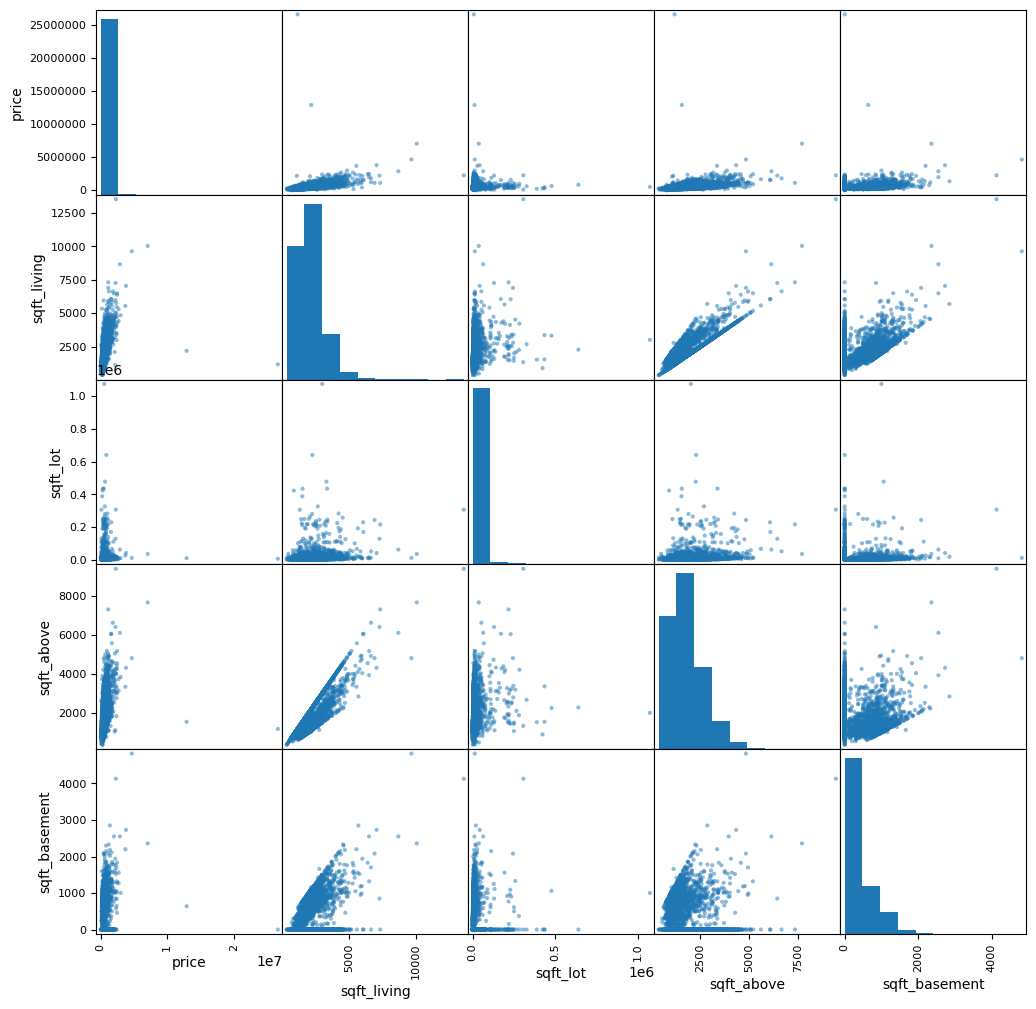

In [15]:
train_df = pd.concat([X_train, y_train], axis = 1)
attributes = ["price","sqft_living", "sqft_lot", "sqft_above", 'sqft_basement']

scatter_matrix(train_df[attributes], figsize = (12,12))
plt.show()

The distributions for the sqft features look a lot better now especially the sqft_lot. Now we can standardize the values to help get the values of each feature around the same scale. Standardization is also less affected by outliers which is great for the dataset since there is a couple outliers for some features.

In [16]:
from src.features import add_basement_features
X_train_encoded = add_basement_features(X_train_encoded)
X_test_encoded = add_basement_features(X_test_encoded)

X_train_encoded.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,...,city_Seattle,city_Shoreline,city_Skykomish,city_Snoqualmie,city_Snoqualmie Pass,city_Tukwila,city_Vashon,city_Woodinville,city_Yarrow Point,has_basement
1992,4.0,1.75,12.599210,8.704834,1.0,0,2,3,10.913929,8.87904,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
871,3.0,2.50,10.829321,9.177301,2.0,0,0,3,10.829321,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
843,3.0,2.50,11.396038,7.416378,2.0,0,0,3,10.567218,6.69433,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2708,4.0,2.75,13.803374,8.923325,2.0,0,0,3,13.803374,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
380,4.0,2.00,12.407314,8.847935,1.5,0,0,5,12.407314,0.00000,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [17]:
from sklearn.preprocessing import StandardScaler
standard_scaler = StandardScaler()
X_train_scaled_nparray = standard_scaler.fit_transform(X_train_encoded)
X_train_scaled = pd.DataFrame(X_train_scaled_nparray, index = X_train_encoded.index, columns = X_train_encoded.columns)
X_train_scaled.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,...,city_Seattle,city_Shoreline,city_Skykomish,city_Snoqualmie,city_Snoqualmie Pass,city_Tukwila,city_Vashon,city_Woodinville,city_Yarrow Point,has_basement
1992,0.682752,-0.519269,0.001884,-0.316153,-0.951048,-0.084819,2.240026,-0.674857,-0.586298,1.199345,...,1.395481,-0.161924,-0.023447,-0.122713,-0.016577,-0.088045,-0.084819,-0.153695,-0.033168,1.238878
871,-0.438230,0.445744,-0.982340,0.200884,0.903661,-0.084819,-0.312391,-0.674857,-0.634607,-0.784361,...,-0.716599,-0.161924,-0.023447,-0.122713,-0.016577,-0.088045,-0.084819,-0.153695,-0.033168,-0.807182
843,-0.438230,0.445744,-0.667192,-1.726154,0.903661,-0.084819,-0.312391,-0.674857,-0.784264,0.711249,...,1.395481,-0.161924,-0.023447,-0.122713,-0.016577,-0.088045,-0.084819,-0.153695,-0.033168,1.238878
2708,0.682752,0.767416,0.671513,-0.077051,0.903661,-0.084819,-0.312391,-0.674857,1.063531,-0.784361,...,-0.716599,-0.161924,-0.023447,-0.122713,-0.016577,-0.088045,-0.084819,-0.153695,-0.033168,-0.807182
380,0.682752,-0.197598,-0.104828,-0.159552,-0.023693,-0.084819,-0.312391,2.299090,0.266403,-0.784361,...,1.395481,-0.161924,-0.023447,-0.122713,-0.016577,-0.088045,-0.084819,-0.153695,-0.033168,-0.807182


In [18]:
from src.features import apply_standard_scaler
X_test_scaled = apply_standard_scaler(X_test_encoded, standard_scaler)

# Target Variable
Let's look at the distribution for target variable, to see if we should do any transformations on it and any scaling on it.

In [19]:
y_test[y_test['price'] == 0].count()

price    0
dtype: int64

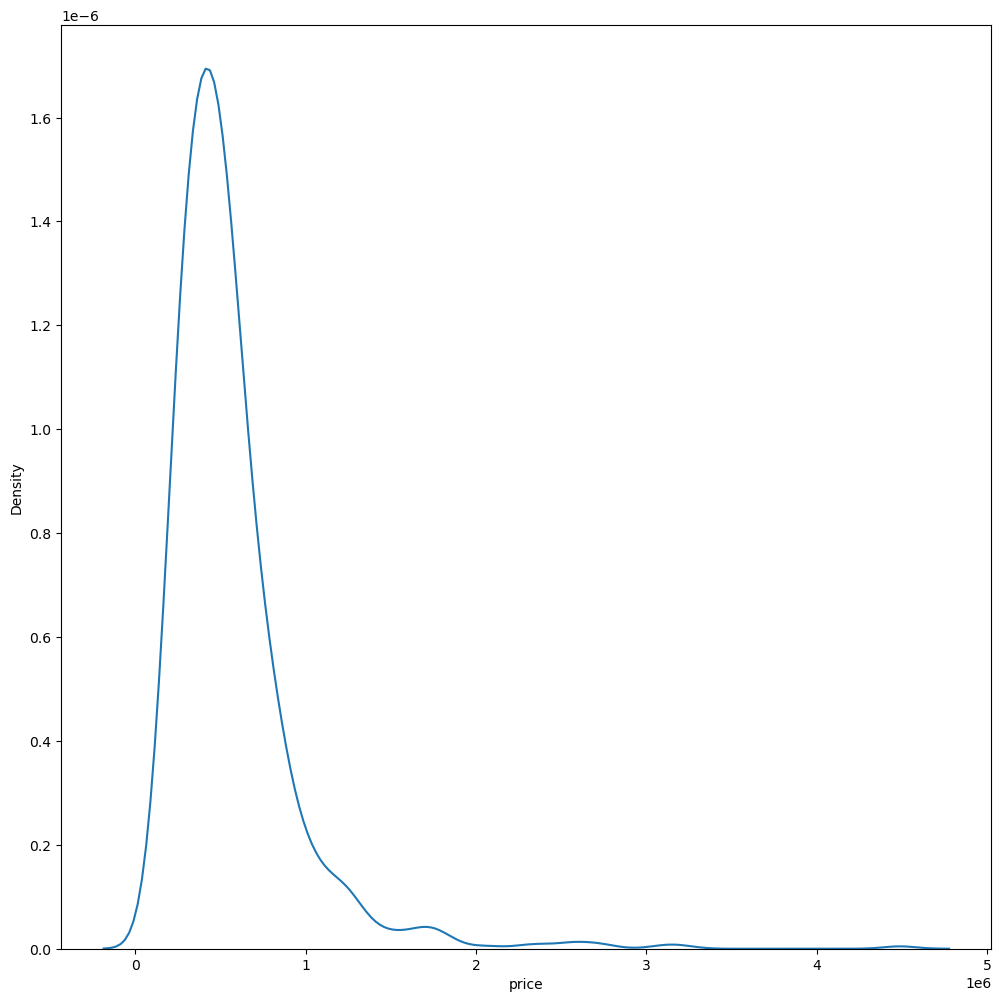

In [20]:
fig = plt.figure(figsize = (12,12))
sns.kdeplot(x='price', data = y_test)
plt.show()

The target variable's distrubution is right skewed, has a pointy peak, and a heavy right tail. To deal with this, a log transform will be applied to the data to normalize the distribution.

In [21]:
y_test_log = np.log(y_test)
y_test_log

,price
1669,12.847927
3963,13.997832
1713,12.994530
873,13.444447
2777,12.923912
...,...
3402,13.241923
2984,13.171154
2968,12.899220
2722,12.751300


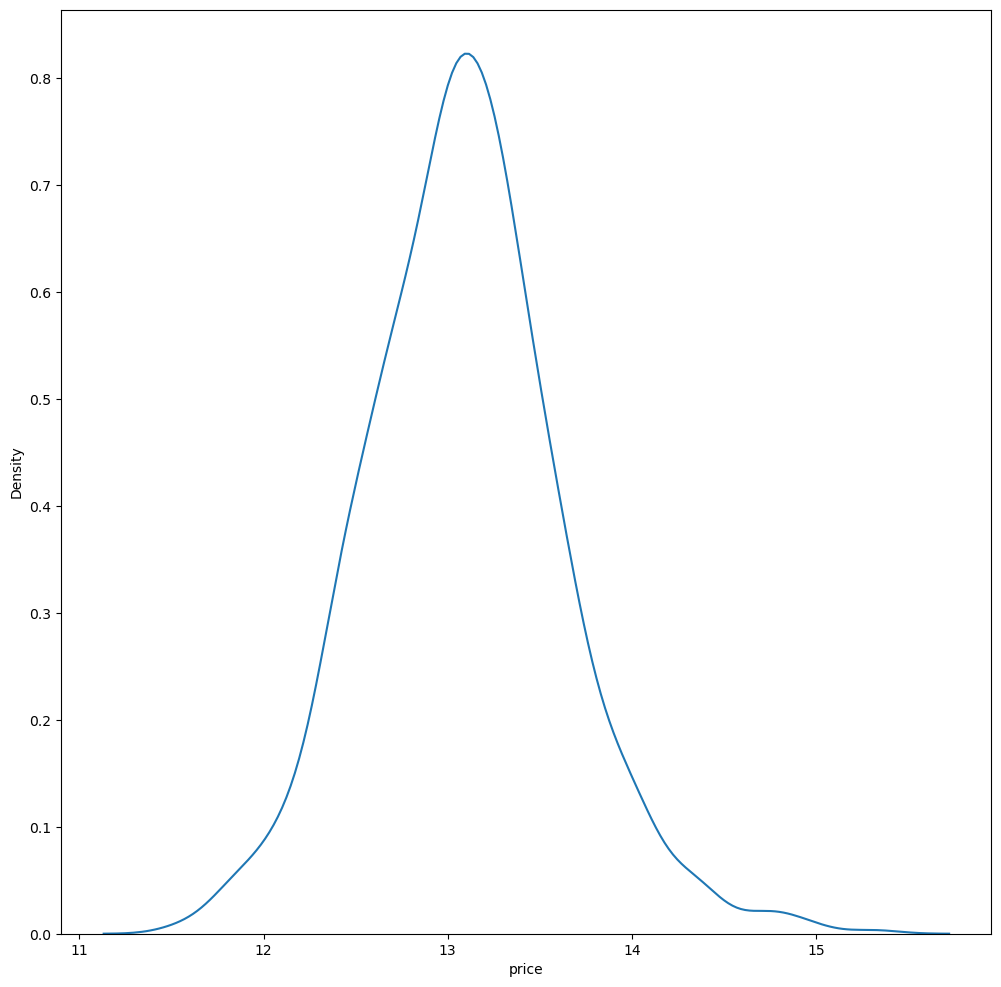

In [22]:
fig = plt.figure(figsize = (12,12))
sns.kdeplot(x='price', data = y_test_log)
plt.show()

Now the data looks more like a normal distrubution.